In [1]:
# First we have to import some tools

import numpy as np
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

Using TensorFlow backend.


# Our dataset: handwritten digits
Before we create and train a model, we have to get some data. We'll be training our network to recognize images of handwritten digits - an easy task for a person, but it would be very difficult to write code that does the same thing without using machine learning.

We keep the training and test data separate so we can confirm that our model is able to make predictions on image that it never "saw" when it was being trained.

When we download our data, `x_train_raw` will hold the images we'll be using to train our network, and `y_train_raw` will have the integers that are drawn in those images. Similarly, `x_test_raw` will have the images we'll use to test our accuracy and `y_test_raw` will hold the integers we're trying to find. 

They're suffixed with `_raw` because we'll need to do some preprocessing before we can use this data to train.

In [2]:
# First we'll download the data
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()


# Let's see what we're working with here
print()
print('Shape of x_train_raw:', x_train_raw.shape)
print('Shape of y_train_raw:', y_train_raw.shape) 

# The (60000, 28, 28) means there are 60,000 samples in x_train, and each sample is a 2D array with 28 rows and 28 columns
# The (60000,) means there are 60,000 values in y_train


Shape of x_train_raw: (60000, 28, 28)
Shape of y_train_raw: (60000,)


Let's look at some of the images we'll be training on.
- Each one is 28 pixels by 28 pixels, and totally black and white.
- The 28 rows and 28 columns of numbers in the training data correspond to the 28 rows and 28 columns of pixels in the image.
- The darkness of each pixel is represented as a number in the training data, where 0 is a white pixel and 255 is a black pixel. 

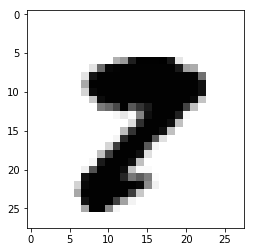

This image represents the number 9


In [3]:
# Change the value of i and re-run this cell to look at different samples. There's 60,000 to choose from!
i = 39423

# Most of them are readable, but some are really tough to make out.
# Some particularly weird samples are where i equals 34707, 39423, 19868, 54756, 12416, and 47217

plt.imshow(x_train_raw[i], cmap='Greys', interpolation='nearest')
plt.show()

print('This image represents the number', y_train_raw[i])

### Preparing the data for training

**Reshaping x**

Our neural network will have 784 neurons in the input layer - one for each pixel in a sample image. To prepare the data for training we'll reshape `x_train` and `x_test` so that each sample is a 1D array of 784 numbers.

In [4]:
x_train = x_train_raw.reshape((60000, 784))
x_test = x_test_raw.reshape((10000, 784))

**Rescaling x**

We'll also rescale the values of `x_train` and `x_test` to be between -1 and 1. We do this because the activation functions have their best sensitivity near 0, and scaling the data so that the activation function can be sensitive to it helps training go faster.

In [5]:
x_train = x_train / (255/2) - 1
x_test = x_test  / (255/2) - 1

**Categorical encoding y**

We'll also change the values of `y_train` and `y_test` from integers to a categorical encoding. The new values will be arrays of length 10, where all the values are 0 except where the index is the desired number, which will be 1. For example, if the number represented in the image was 2, the cateorical encoding would be `[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]` (since the third position has index 2).

Why did we do this? This way our output layer will have 10 neurons, where each neuron corresponds to a different number. We can look at the output from the network to get a better sense of how high a confidence our network has in the image being a certain number.

In [6]:
y_train = to_categorical(y_train_raw)
y_test = to_categorical(y_test_raw)

---
# Building the neural network

It's time for you to build your network! Here's a brief overview of how to work with Keras to get you started.


**You can create a new model by calling ```Sequential```**

For example:
```
model = Sequential()
```


**You can add layers to your model with `model.add(`layer`)`**

`Dense` layers are fully connected, with each neuron in the previous layer being connected to each neuron in the new layer. The number you pass as an argument is the number of new neurons that are created.

Since the input layer doesn't actually do anything, the first layer you create with Keras is really the first *hidden* layer. It has to know how many inputs to expect, which you can specify with `input_shape`. After the first layer, no other layer needs `input_shape`.

For example:
```
model.add(Dense(100, input_shape=(784,)))
```

**After adding a `Dense` layer, you can add an `Activation` layer.**

This layer represents the activation functions for all the neurons in the layer before it. There are plenty of choices of actiation functions: `'sigmoid'`, `'hard_sigmoid'`, `'relu'`, `'softplus'`, `'tanh'`, `'softsign'`, `'softmax'`, `'elu'`, `'selu'`, and `'linear'`. If you're curious about what these activation functions look like, google is your friend!

For example:
```
model.add(Activation('relu'))
```

**Add as many layers as you like, alternating `Dense` and `Activation`**

The last layer of your model should have the same number of neurons as the number of values you want to predict. For our data, that's 10.

As a baseline, here's a complete example network:
```
model.add(Dense(100, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(10))
```


In [7]:
# Create your model! I'll start you off by initializing it, but it's up to you to add layers.

model = Sequential()

model.add(Dense(100, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(10))

### Compiling the model
Once the model is built, it has to be compiled with `model.compile`

The `'optimizer'` is the strategy you want to use to find the right weights and biases for your model. A solid go-to choice is `'adam'`, but there are many others: `'sgd'`, `'rmsprop'`, `'adagrad'`, `'adadelta'`, `'adamax'`, and `'nadam'`.

The `loss` argument describes the way you want the optimizer to gauge the correctness of the model. We'll be using `'categorical_crossentropy'` for this model.

In [8]:
# The compiling step. Feel free to pick your own optimizer! 

model.compile(optimizer='adam', loss='categorical_crossentropy')

### Training the model

We'll be using the data in `x_train_prepared` and `y_train_prepared` to fit the weights and biases in our model. 

The number of `epochs` is the number of times the model trains on every sample of the training set. More epochs means the model gets more opportunities to learn from the data, but it means the model takes longer to train. 

Too many epochs can also lead to *overfitting*, where instead of learning a general solution to the problem, the model essentially "memorizes" the answers for the examples it was trained on. If this happens, the accuracy on the training set is very high, while the accuracy on the test set is low. This is one of the reasons we keep the training and test sets separate, so we can tell if our model has been overfit.

In [9]:
# Set the number of epochs to train your model

model.fit(x_train, y_train, epochs=1)

Epoch 1/1
60000/60000 [==============================] - 5s - loss: 10.1789     


### Evaluating the model

There's a lot of different ways to evaluate a model's performance after it's been trained. One of the most straightforward ways is to look at its accuracy, which is the percent of samples it predicted correctly.

We'll use the test set data (that wasn't used during training) to calculate you model's accuracy.

In [11]:
predictions = model.predict(x_test)
print("Accuracy: %", accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1)) * 100)
print()

correct_preds = (y_test == np.round(predictions)).all(axis=1)
print("That means that out of", y_test.shape[0] ,"test samples, this model got", 
      np.where(correct_preds)[0].size, "correct and",
      np.where(~correct_preds)[0].size, "incorrect")

Accuracy: % 19.68

That means that out of 10000 test samples, this model got 0 correct and 10000 incorrect


We can also assess the model's performance with a confusion matrix. In this matrix, rows and columns represent actual numbers and predicted numbers for each sample of the test set. 
- If the number 900 is at row 6 and column 6 of the confusion matrix, that means that there were 900 samples where model predicted that the image was a drawing of a 6 and it was right
- If the number 17 is at row 4 and column 9, that means that there were 17 times where the model predicted a 9, but the image was actually showing a 4

In this heatmap, the diagonal stripe represents all the samples the model got right: when it predicted 0 for a 0, 1 for a 1, etc. Every other part of the matrix represents samples that the model got wrong.

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="viridis", vmax=100, annot=True, fmt='g')
plt.gca().set_xlabel("Predicted number", fontsize=16)
plt.gca().set_ylabel("Actual number", fontsize = 16)
plt.show()